# Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin
from utils import geometric_median, geometric_medoid
from math import floor, ceil, sqrt
from NMF_iter import normalize_curves
from scipy.stats import levene

from itertools import permutations

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [3]:
def plot_components(H_dict, nrows=None, ncols=None, figsize=(20, 10)):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(H_dict)))
        ncols = ceil(len(H_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    for idx, (method, H) in enumerate(H_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        abscissa = np.linspace(0, 24, H.shape[1])
        for k in range(H.shape[0]):
            label = f'Component {k + 1}'
            if 'smoothed' in method:
                marker=None
            else:
                marker = 'o'
            axs[i,j].plot(abscissa, H[k, :], marker=marker, linestyle='-', label=label)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [4]:
def plot_residual_curves(residuals_dict, n_curves_plotted=10, nrows=None, ncols=None, figsize=(20, 10), **kwargs):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(residuals_dict)))
        ncols = ceil(len(residuals_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    curves_to_plot = random.sample(range(next(iter(residuals_dict.values())).shape[0]), n_curves_plotted)

    for idx, (method, resid) in enumerate(residuals_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        for n in curves_to_plot:
            axs[i,j].plot(resid.iloc[n, :], marker='o', linestyle='-', **kwargs)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        # axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [5]:
def plot_residual_boxplots(residuals_with_info, nrows=None, ncols=None, figsize=(20, 10), rotate_xlabels=False, **kwargs):
    nrows = floor(sqrt(len(residuals_with_info)))
    ncols = ceil(len(residuals_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)

    for idx, (method, resid_df)  in enumerate(residuals_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            resid_df,
            y='residual',
            ax=axs[i, j],
            **kwargs
        )
        axs[i, j].set_title(method)
        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [6]:
def plot_random_reconstructed(reconstructed, X, n_obs=4, override_methods=None, figsize=(20,10), **kwargs):
    nrows = floor(sqrt(n_obs))
    ncols = ceil(n_obs / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
    
    first_element = next(iter(reconstructed.values()))
    random_curves_idx = random.sample(first_element.index.to_list(), n_obs)

    for idx, name in enumerate(random_curves_idx):
        i = idx // ncols
        j = idx % ncols
        for method, recons in reconstructed.items():
            if override_methods:
                if method in override_methods:
                    axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
            else:
                axs[i,j].plot(recons.loc[name], marker='o', linestyle='-', label=method, **kwargs)
        axs[i,j].plot(X.loc[name], marker='o', linestyle='-', label='True curve', **kwargs)
        axs[i,j].set_xlabel('Hour')
        axs[i,j].set_title(name)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [7]:
info_cols = ['region', 'year', 'month', 'daytype']

def plot_concentrations_boxplots(W_with_info, nrows=None, ncols=None, figsize=(20, 10), rotate_xlabels=False, title=None, replicate_legend=True, **kwargs):
    nrows = floor(sqrt(len(W_with_info)))
    ncols = ceil(len(W_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)

    for idx, (method, W_df)  in enumerate(W_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            W_df.melt(id_vars=info_cols, var_name='component', value_name='concentration'),
            y='concentration',
            ax=axs[i, j],
            **kwargs
        )
        axs[i, j].set_title(method)
        
        if not replicate_legend and idx != 0:
            axs[i, j].get_legend().remove()

        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [8]:
max_n_components = 4
colormap = ListedColormap([colors[k] for k in range(max_n_components)])

# Load results and input data

## NMF Results

In [9]:
method_names = [
    'WHopt_3comp_1000runs',
    'WHopt_3comp_10000runs',
    'WHopt_3comp_smoothed_1000runs',
    'FPCA_3PCs',
    'WHopt_4comp_1000runs',
    'WHopt_4comp_10000runs',
    'WHopt_4comp_smoothed_1000runs',
    'FPCA_4PCs',
]

nmf_method_names = [method for method in method_names if 'PCA' not in method]

W = {}
H = {}

for method in nmf_method_names:
    data = np.load('data/nmf_results/' + method + '.npz', allow_pickle=True)
    W[method] = data['W']
    H[method] = data['H']

In [10]:
# Align the components
ref_H = H['WHopt_3comp_1000runs']

for method in nmf_method_names:

    n_comp = H[method].shape[0]
    ref_n_comp = ref_H.shape[0]
    best_permutation = list(range(n_comp))
    n_eval_points = H[method].shape[1]
    eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
    best_alignment = np.linalg.norm(ref_H - H[method][np.ix_(range(ref_n_comp), eval_points)], 'fro')

    for permutation in list(permutations(range(n_comp))):
        alignment = np.linalg.norm(ref_H - H[method][np.ix_(list(permutation)[:ref_n_comp], eval_points)], 'fro')

        if alignment < best_alignment:
            best_alignment = alignment
            best_permutation = list(permutation)

    H[method] = H[method][best_permutation, :]
    W[method] = W[method][:, best_permutation]

In [11]:
# Align 4comp between them
ref_method = 'WHopt_4comp_1000runs'
ref_H = H[ref_method]

for method in [method for method in nmf_method_names if '4comp' in method and method != ref_method]:

    n_comp = H[method].shape[0]
    ref_n_comp = ref_H.shape[0]
    best_permutation = list(range(n_comp))
    n_eval_points = H[method].shape[1]
    eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
    best_alignment = np.linalg.norm(ref_H - H[method][np.ix_(range(ref_n_comp), eval_points)], 'fro')

    for permutation in list(permutations(range(n_comp))):
        alignment = np.linalg.norm(ref_H - H[method][np.ix_(list(permutation)[:ref_n_comp], eval_points)], 'fro')

        if alignment < best_alignment:
            best_alignment = alignment
            best_permutation = list(permutation)

    H[method] = H[method][best_permutation, :]
    W[method] = W[method][:, best_permutation]

## Input data

In [12]:
input_df = pd.read_csv('data/daily_curves_fixed.csv', index_col=0)
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

11646


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,828.180,831.509,758.732,669.630,596.548,518.853,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,819.056,825.176,754.773,706.062,629.708,540.431,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,980.735,926.445,845.014,756.975,688.183,601.762,Calabria,2021,01,Working day


In [13]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = normalize_curves(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Calabria_2021-01-02_Saturday,0.036819,0.034283,0.030778,0.029892,0.030469,0.030777,0.032800,0.035052,0.038599,0.043163,...,0.043207,0.043862,0.049662,0.051500,0.055146,0.055368,0.050522,0.044589,0.039722,0.034549
Calabria_2021-01-03_Holiday,0.034625,0.030556,0.028842,0.027966,0.026293,0.029277,0.030860,0.032600,0.035530,0.042834,...,0.045282,0.044483,0.048738,0.050998,0.054659,0.055067,0.050369,0.047118,0.042023,0.036065
Calabria_2021-01-04_Working day,0.030835,0.025677,0.024763,0.024702,0.024831,0.026079,0.029497,0.035669,0.039430,0.050540,...,0.048232,0.045538,0.049652,0.050852,0.055957,0.052859,0.048213,0.043190,0.039265,0.034334
Calabria_2021-01-05_Working day,0.034956,0.031889,0.030023,0.029715,0.028913,0.030107,0.033811,0.039218,0.043283,0.053841,...,0.046168,0.044271,0.047506,0.051417,0.051633,0.050358,0.046345,0.040047,0.035615,0.030337
Calabria_2021-01-06_Holiday,0.033561,0.029616,0.028412,0.028415,0.027903,0.028700,0.029924,0.032797,0.035796,0.046258,...,0.046951,0.044372,0.047203,0.051273,0.052255,0.050949,0.048430,0.044395,0.040193,0.035674


## PCA-reconstructed signal

In [14]:
n_pcs = [3, 4]
X_fpca = {}

for k in n_pcs:
    X_fpca[f'FPCA_{k}PCs'] = pd.read_csv(f'data/daily_curves_reconstructed_{k}PCs.csv', index_col=0)
    X_fpca[f'FPCA_{k}PCs'].columns = pd.to_numeric(X_fpca[f'FPCA_{k}PCs'].columns)

# Compare profiles found

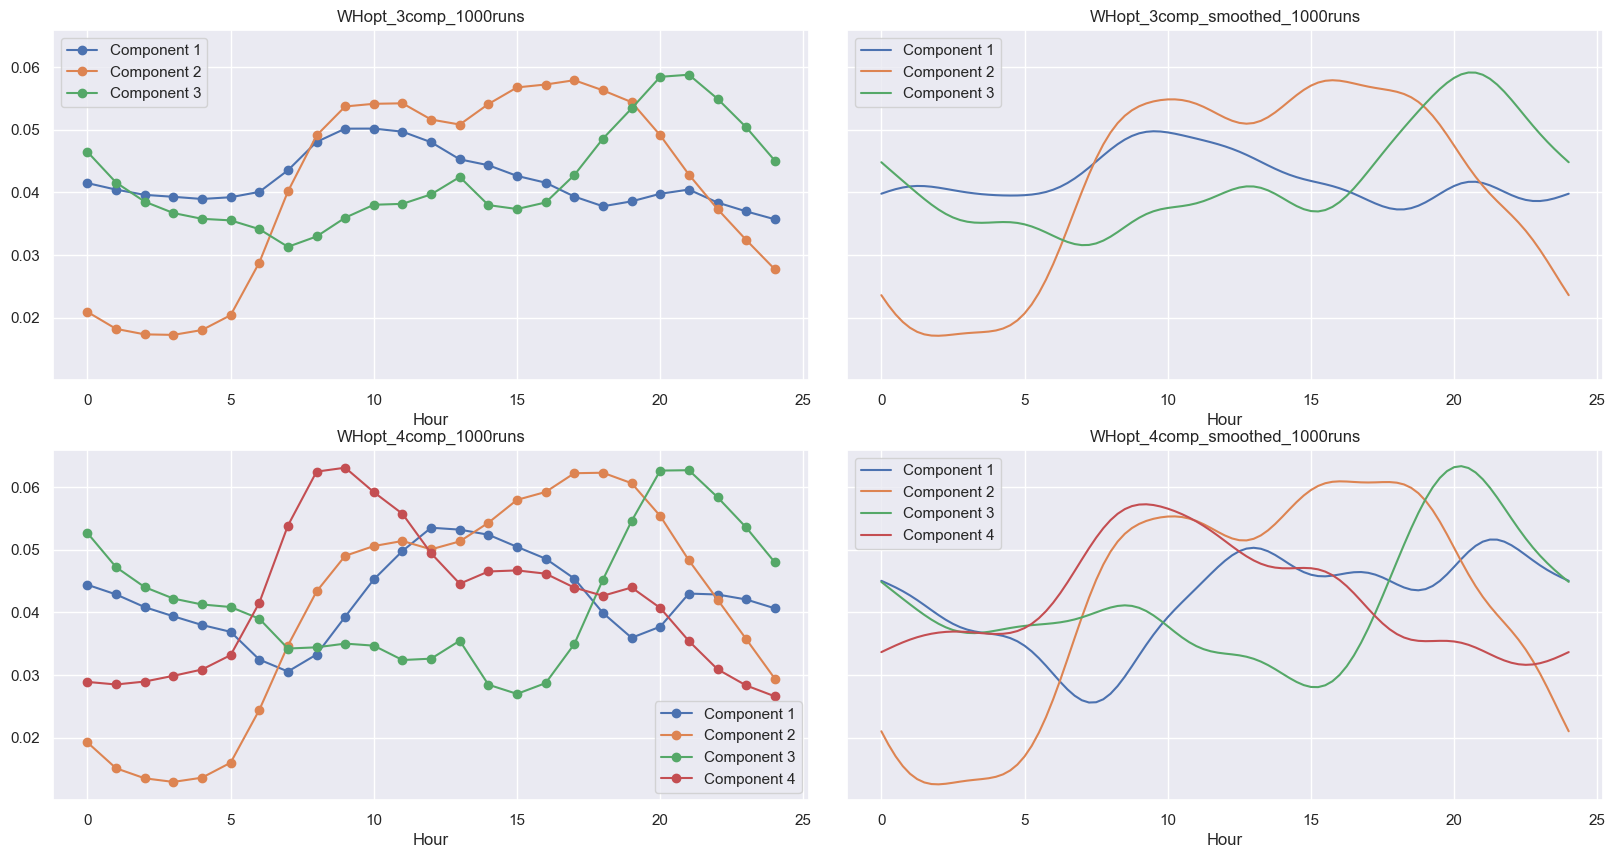

In [15]:
fig, axs = plot_components(H, nrows=2, ncols=2, figsize=(20, 10))

# Assess assumptions on the residuals

In [16]:
reconstructed = {}
residuals = {}

for method in method_names:
    if method not in nmf_method_names:
        reconstructed[method] = X_fpca[method]
    else:
        reconstructed_smooth = np.dot(W[method], H[method])
        n_eval_points = H[method].shape[1]
        reconstructed[method] = pd.DataFrame(reconstructed_smooth[:, np.arange(0, n_eval_points, int(n_eval_points / 24))], index=input_df.index)

    residuals[method] = X.values - reconstructed[method]

## Residual curves

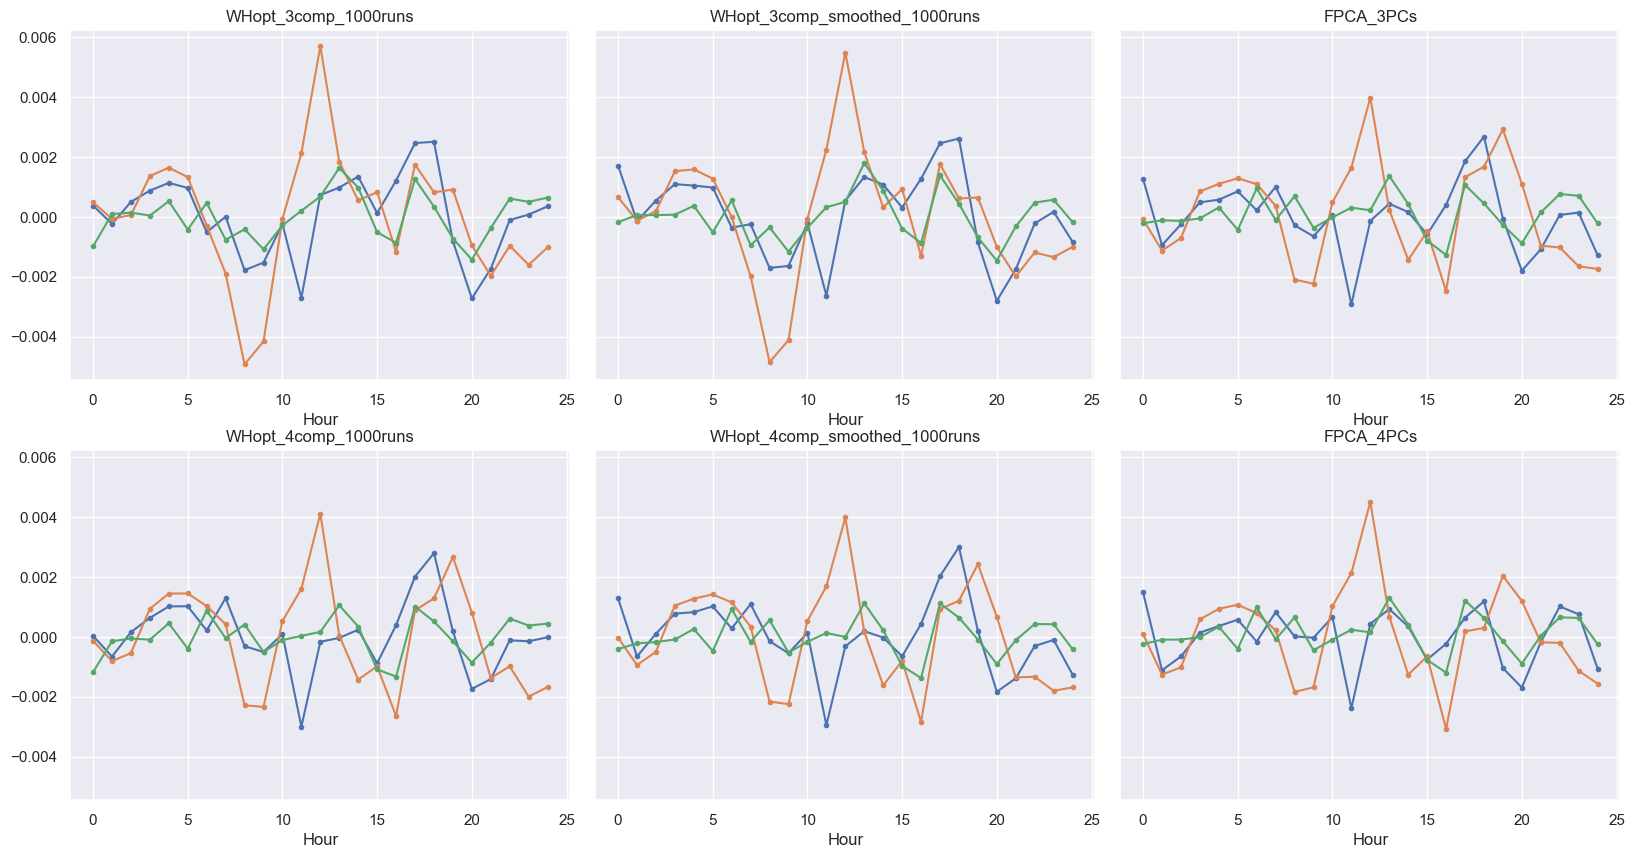

In [40]:
fig, axs = plot_residual_curves(residuals, n_curves_plotted=3, figsize=(20, 10), markersize=3)

## Residual histograms

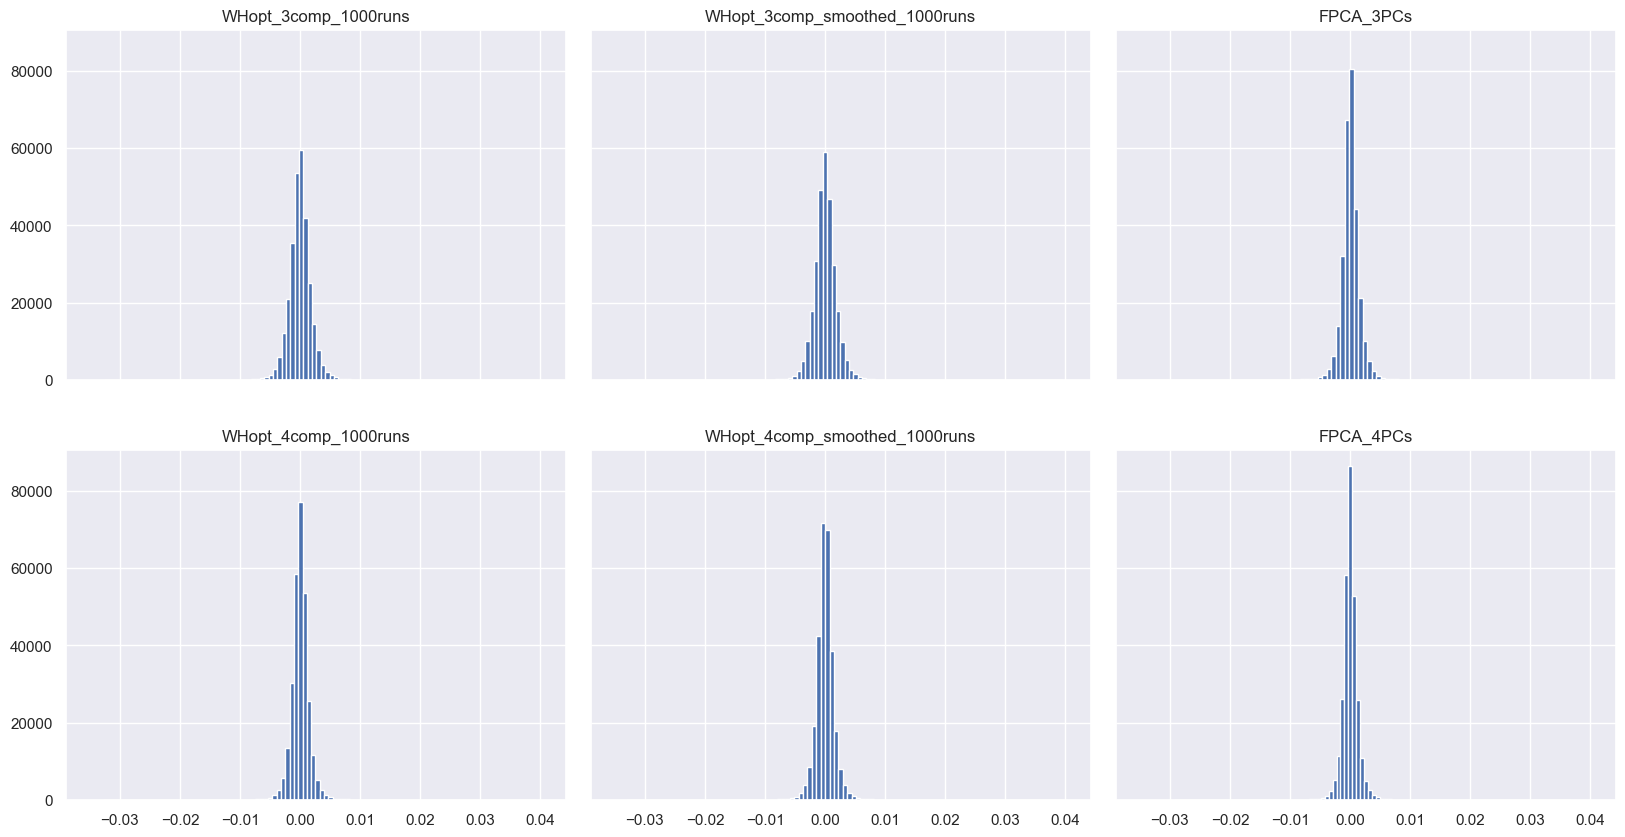

In [41]:
nrows = floor(sqrt(len(method_names)))
ncols = ceil(len(method_names) / nrows)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10), sharex=True, sharey=True)

for idx, (method, E)  in enumerate(residuals.items()):
    resid = E.values.flatten()
    i = idx // ncols
    j = idx % ncols
    axs[i, j].hist(resid, bins=100)
    axs[i, j].set_title(method)
plt.subplots_adjust(wspace=0.05)

## Homoschedasticity

In [19]:
residuals_with_info = {}

for method in method_names:
    resid_df = pd.concat([residuals[method], unit_info], axis=1)
    resid_df = resid_df.melt(id_vars=info_cols, var_name='hour', value_name='residual')
    residuals_with_info[method] = resid_df

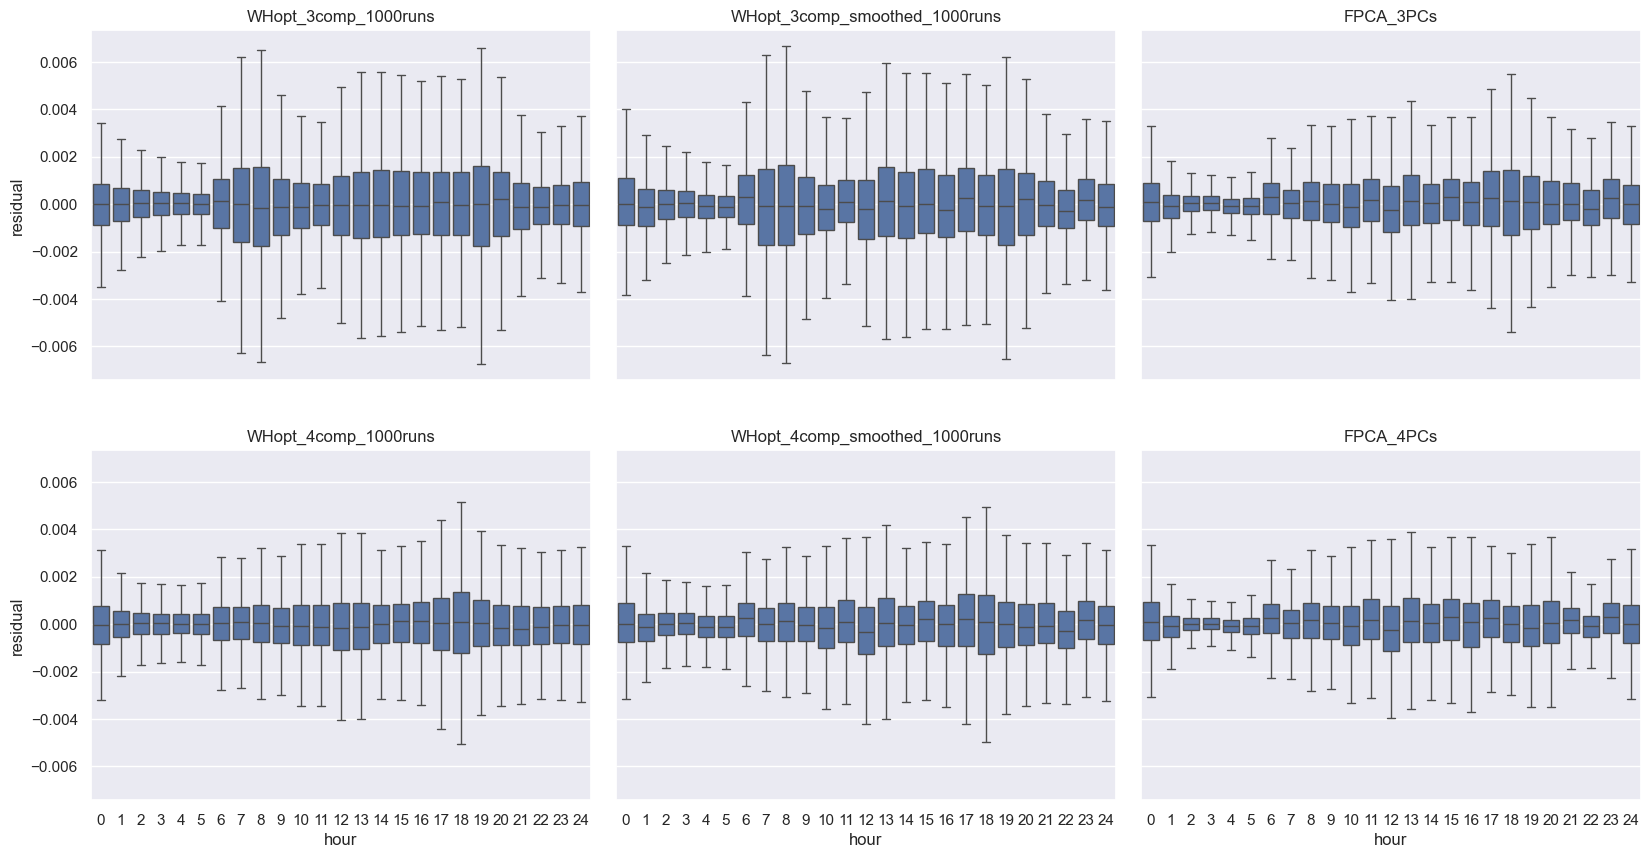

In [20]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='hour', showfliers=False, figsize=(20,10))

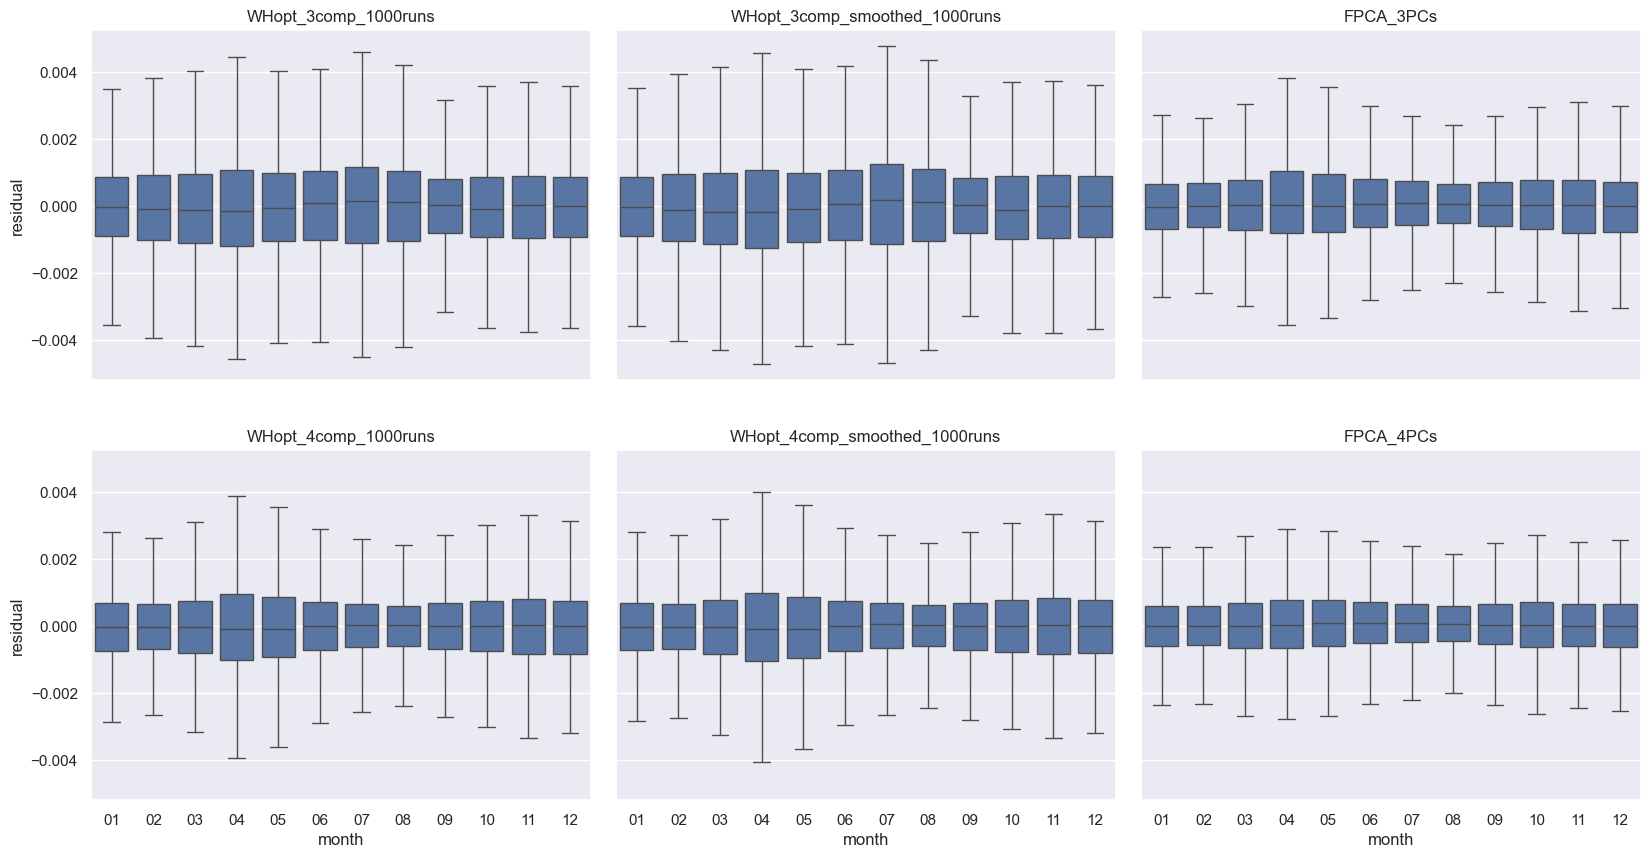

In [42]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='month', showfliers=False)

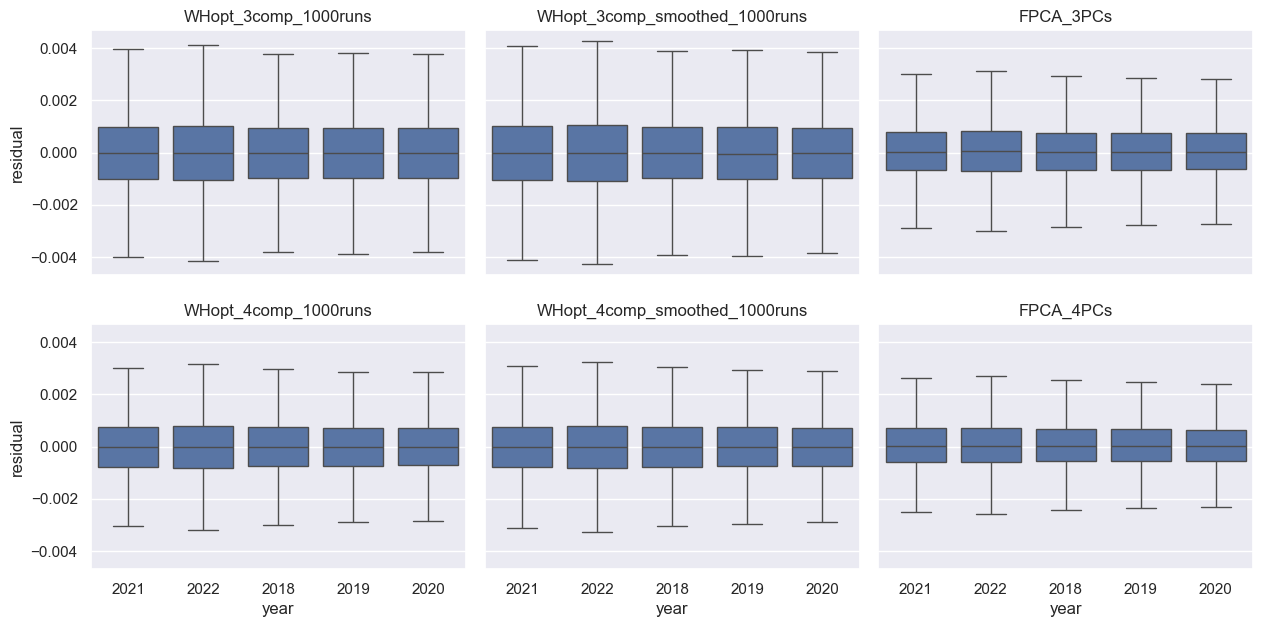

In [44]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='year', showfliers=False, figsize=(15,7))

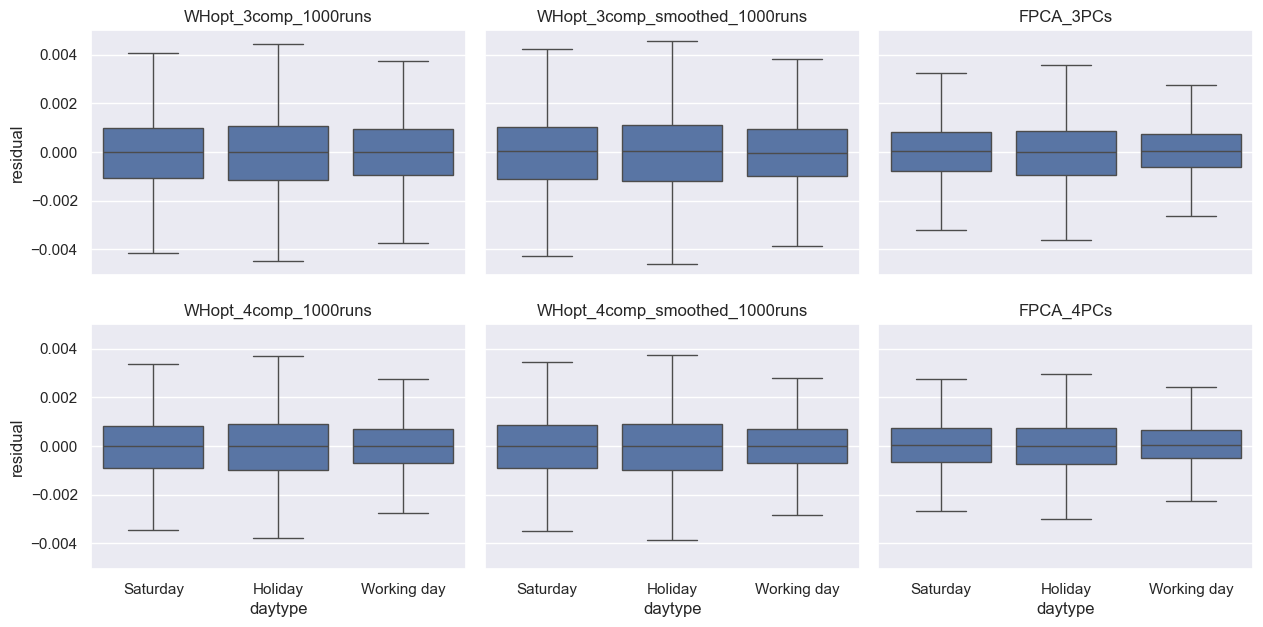

In [45]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='daytype', showfliers=False, figsize=(15,7))

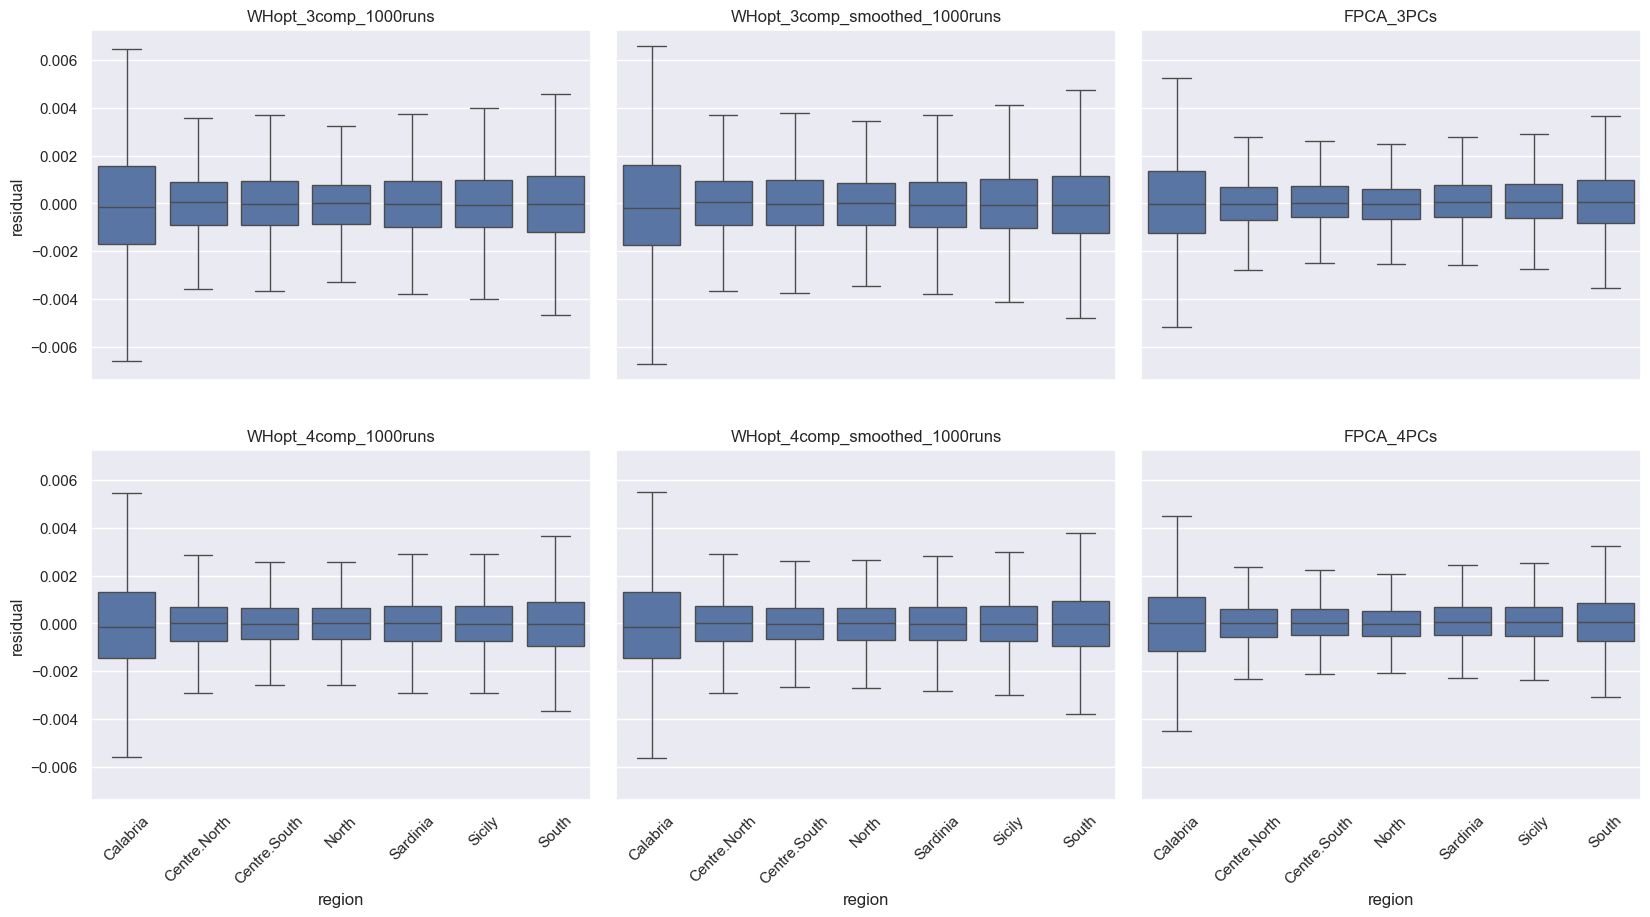

In [24]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='region', showfliers=False, rotate_xlabels=True)

# Compare model fit

In [46]:
print(method_names)

['WHopt_3comp_1000runs', 'WHopt_3comp_smoothed_1000runs', 'FPCA_3PCs', 'WHopt_4comp_1000runs', 'WHopt_4comp_smoothed_1000runs', 'FPCA_4PCs']


In [47]:
# Sample data for groups
method1 = 'WHopt_4comp_smoothed_1000runs'
method2 = 'FPCA_3PCs'

# Performing Levene's test
res1 = residuals_with_info[method1]['residual']
res2 = residuals_with_info[method2]['residual']
statistic, p_value = levene(res1, res2)

# Print estimated variance
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method1, (res1**2).sum(), len(res1)))
print("Sum of squared residuals for {} is {:.4f} for {:,} samples".format(method2, (res2**2).sum(), len(res2)))

# Checking the result
print("\nTest Statistic:", statistic)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print(f"\nReject the null hypothesis")
else:
    print(f"\nFail to reject the null hypothesis")

Sum of squared residuals for WHopt_4comp_smoothed_1000runs is 0.6245 for 291,150 samples
Sum of squared residuals for FPCA_3PCs is 0.6309 for 291,150 samples

Test Statistic: 30.377408985665827
p-value: 3.557960752193853e-08

Reject the null hypothesis


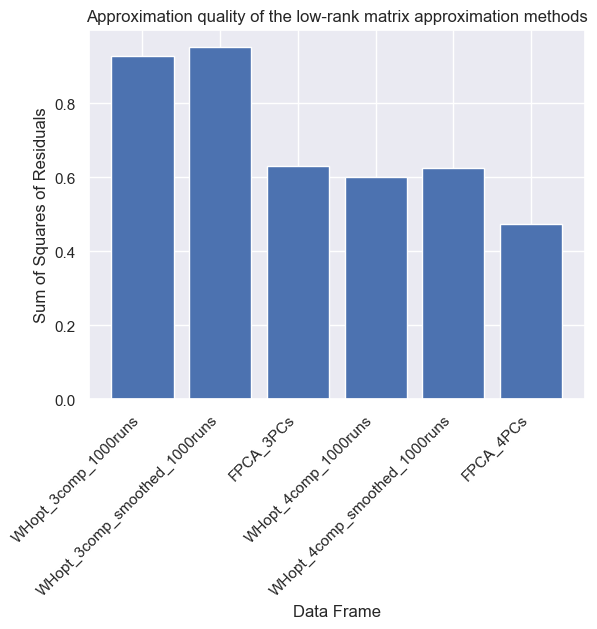

In [27]:
# Initialize lists to store data
labels = []
sums_of_squares = []

# Iterate over the dictionary of data frames
for key, df in residuals_with_info.items():
    # Calculate sum of squares of residuals
    sum_of_squares = (df['residual'] ** 2).sum()
    
    # Append to lists
    labels.append(key)
    sums_of_squares.append(sum_of_squares)

# Create bar plot
plt.bar(labels, sums_of_squares)
plt.xlabel('Data Frame')
plt.ylabel('Sum of Squares of Residuals')
plt.title('Approximation quality of the low-rank matrix approximation methods')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# Showing examples of reconstructed curves

In [28]:
method_names

['WHopt_3comp_1000runs',
 'WHopt_3comp_smoothed_1000runs',
 'FPCA_3PCs',
 'WHopt_4comp_1000runs',
 'WHopt_4comp_smoothed_1000runs',
 'FPCA_4PCs']

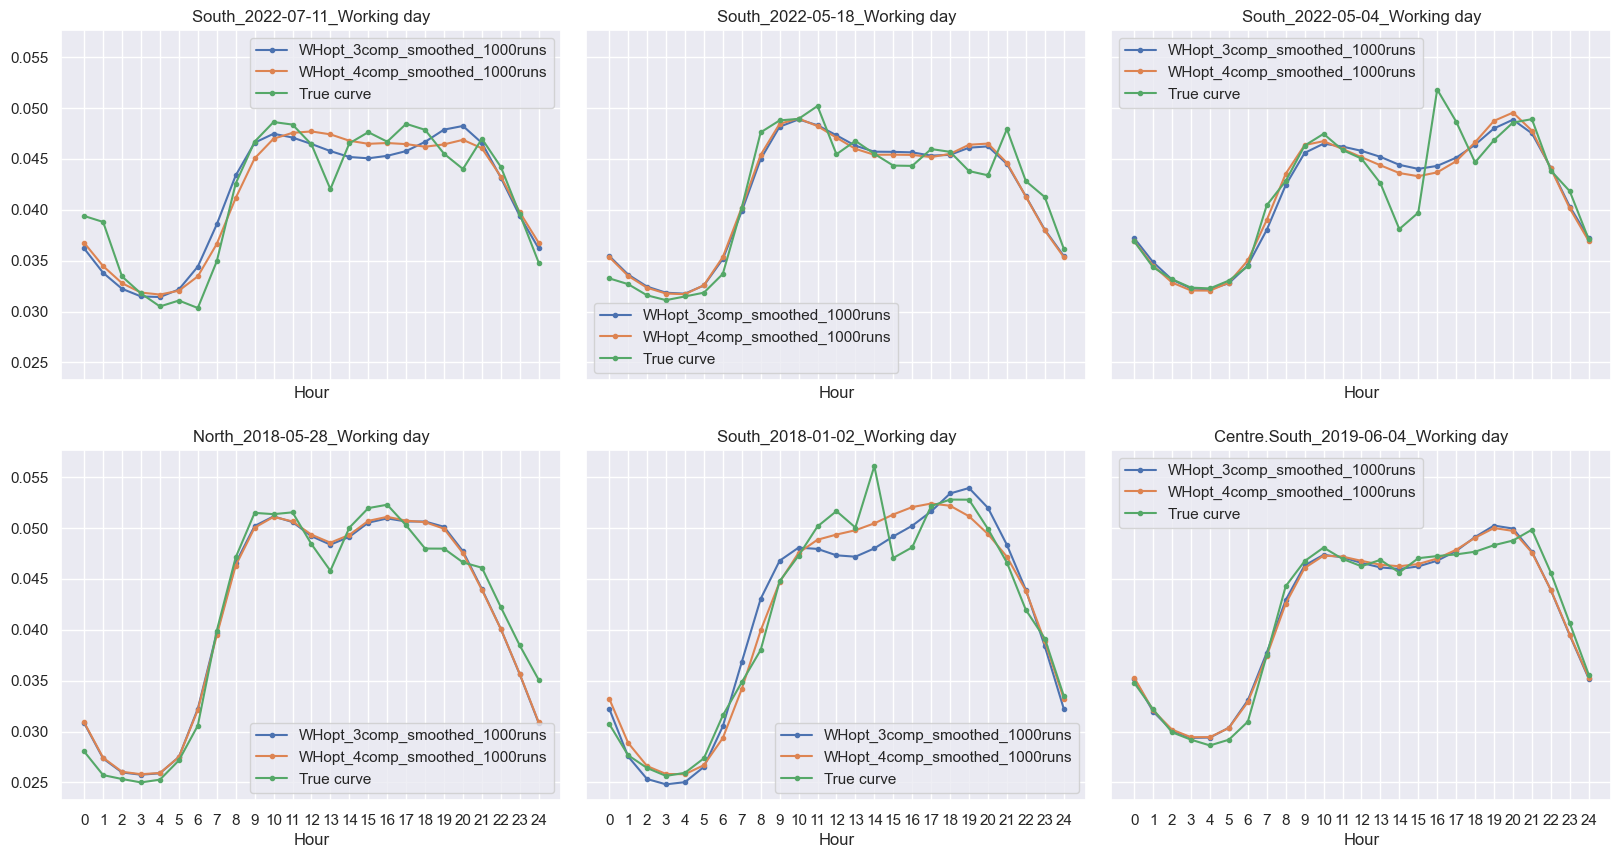

In [29]:
override_methods = ['WHopt_3comp_smoothed_1000runs', 'WHopt_4comp_smoothed_1000runs']
fig, ax = plot_random_reconstructed(reconstructed, X, override_methods=override_methods, n_obs=6, figsize=(20,10), markersize=3)

# Analyse concentrations

In [30]:
W_with_info = {}
for method in nmf_method_names:
    W_df = pd.DataFrame(W[method], index=input_df.index, columns=[f"Component {k+1}" for k in range(W[method].shape[1])])
    W_df = pd.concat([W_df, unit_info], axis=1)
    W_with_info[method] = W_df.sort_values(['year', 'month', 'region'])

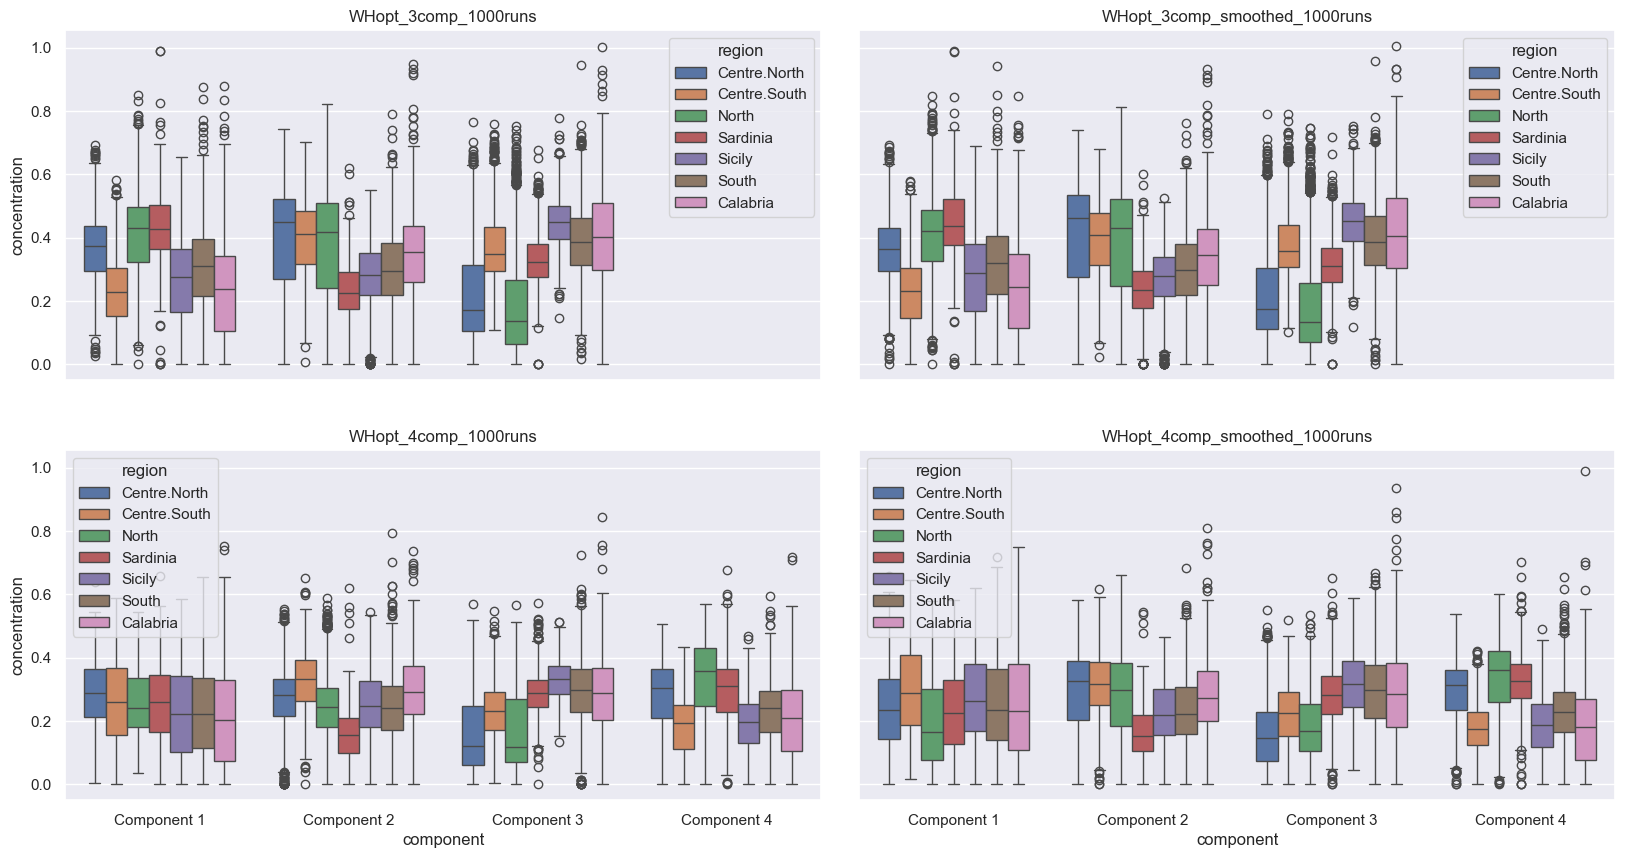

In [31]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='region')

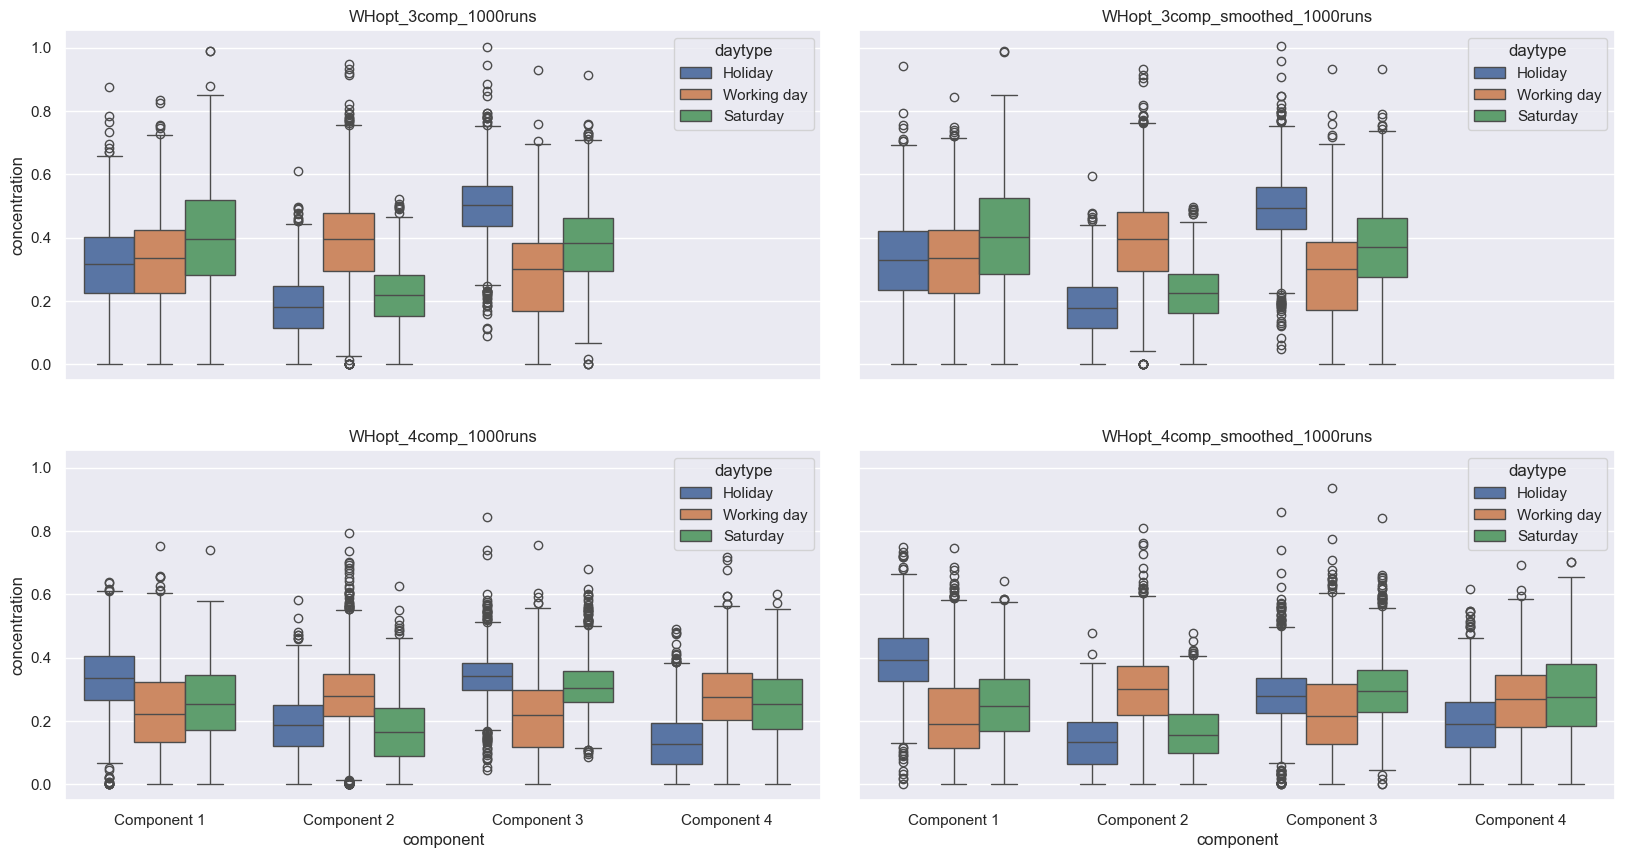

In [32]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='daytype')

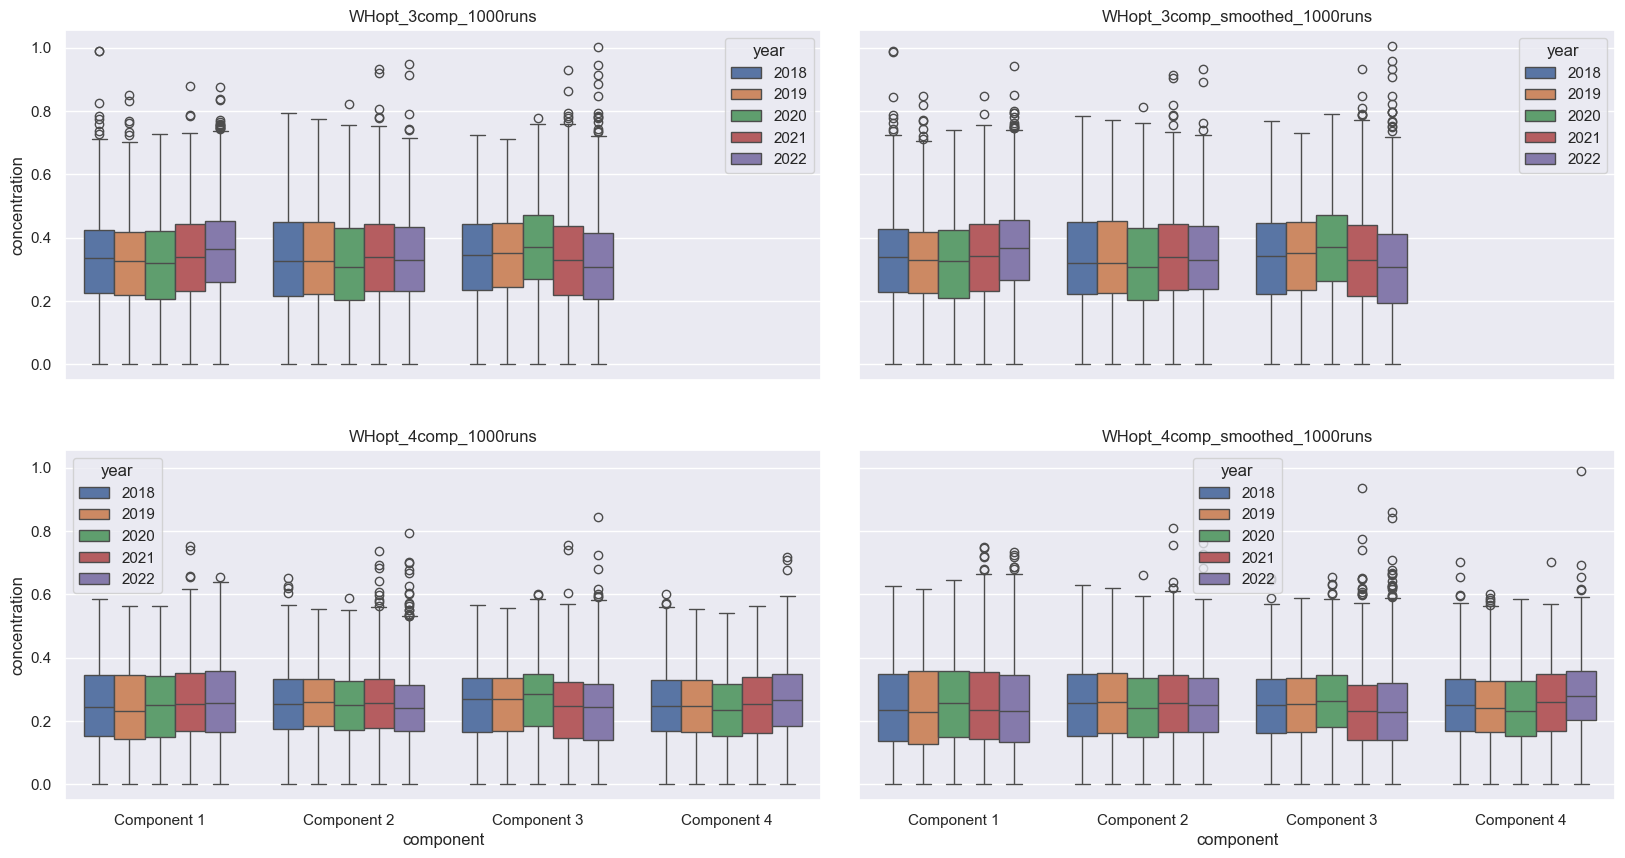

In [33]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='year')

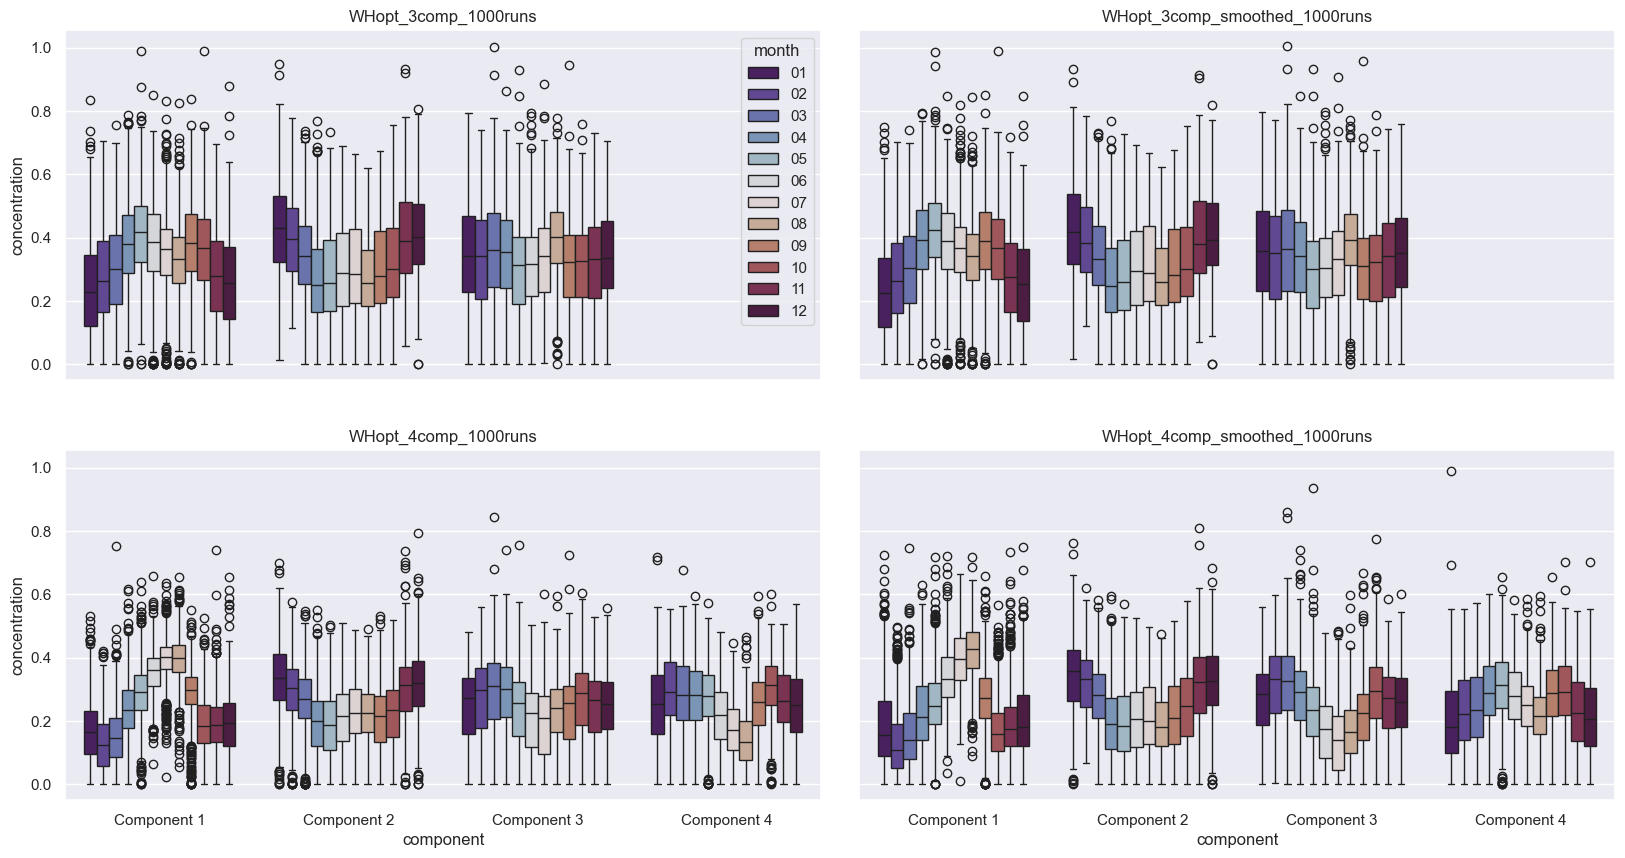

In [48]:
fig, ax = plot_concentrations_boxplots(W_with_info, x='component', hue='month', palette='twilight_shifted', replicate_legend=False)